## Analysis pipline for *Why pathway methods work?* project

### Preprocess gene sets

In [1]:
from subprocess import call
import os
import sys
import pickle as pckl

sys.path.append('../code/')

In [2]:
import numpy as np
import pandas as pd

In [3]:
#getting csv regulons from DoRothEA
call(['Rscript','../code/get_regulon_from_rdata.R'])

0

In [4]:
#getting csv gene sets from msigdb
call(['Rscript','../code/get_msigdb_genesets.R'])

0

In [2]:
import make_genesets

In [3]:
#prepocess dorothea regulons
for confidence in ['A','B','C','D','E','BEST']:
    make_genesets.make_gene_dict_dorothea(confidence)

In [4]:
#multi level gene sets for dorothea
make_genesets.make_multi_level_dorothea()

In [5]:
#prepocess msigdb regulons
for setname in ['BIOCARTA','CGP','KEGG','REACTOME']:
    make_genesets.make_gene_dict_msigdb(setname)

Checking the size of different gene sets.

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [21]:
gene_set_lengths={}
for confidence in ['A','B','C','D','E','AB','ABC','ABCD','ABCDE','BEST']:
    fin=open('../results/genesets/single/dicts/dorothea_%s.pkl' % confidence,'br')
    genesets=pckl.load(fin)
    fin.close()
    l=[len(genesets[x]) for x in genesets.keys()]
    gene_set_lengths['DoRothEA_'+confidence]=np.array(l)
for setname in ['CGP','KEGG','REACTOME','BIOCARTA']:
    fin=open('../results/genesets/single/dicts/%s.pkl' % setname,'br')
    genesets=pckl.load(fin)
    fin.close()
    l=[len(genesets[x]) for x in genesets.keys()]
    gene_set_lengths[setname]=np.array(l)

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


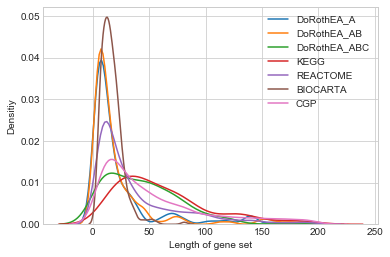

In [24]:
for confidence in ['DoRothEA_A','DoRothEA_AB','DoRothEA_ABC','KEGG','REACTOME','BIOCARTA','CGP']:
    sns.distplot(np.array(gene_set_lengths[confidence])[gene_set_lengths[confidence]<200]
                 ,hist=False,label=confidence)
plt.xlabel('Length of gene set')
plt.ylabel('Densitiy')

In [4]:
import geneset_similarity

In [5]:
setnames=['dorothea_AB','dorothea_ABC','KEGG','BIOCARTA','REACTOME','CGP']
for setname1 in setnames:
    for setname2 in setnames:
        if setname1<setname2:
            geneset_similarity.get_composational_similarity(setname1,setname2)

../code/geneset_similarity.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  data1=data1.loc[all_genes]
../code/geneset_similarity.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  data1=data1.loc[all_genes]
../code/geneset_similarity.py:21: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  data2=data2.loc[all_genes]


In [14]:
#make rdata file from the gene sets for viper
call(['Rscript','../code/make_viper_regulon.R'])

0

### Preprocess benchamrking datasets
Now as we are having our gene sets (and gene set similarities) ready, we need the benchmarking datasets. For benchmarking we will use 2 datasets:
* perturbation gene expression profiles form PROGENy
* tumor vs. normal in TCGA data

In [10]:
import pandas as pd
import numpy as np

In [22]:
#PROGENY prepocess
zscores=pd.read_csv('../data/progeny/zscores_14PW_PROGENy.csv',sep=',',header=0,index_col=0)
indexes=pd.read_csv('../data/progeny/index_14PW_PROGENy.csv',sep=',',header=0,index_col=0)
indexes.index=indexes['id']
del indexes['id']

In [25]:
np.sum(zscores.isna().sum(1)==0)

6684

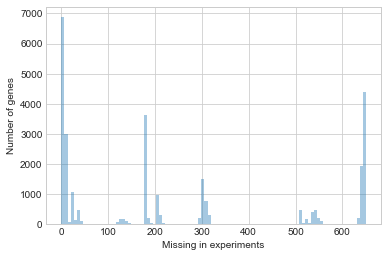

In [27]:
#removing NAs
sns.distplot(zscores.isna().sum(1),norm_hist=False,kde=False,bins=100)
plt.xlabel('Missing in experiments')
plt.ylabel('Number of genes')

In [28]:
#we keep only genes with 0 missing values
fil=zscores.isna().sum(1)==0
zscores=zscores[fil]

In [29]:
zscores.shape

(6684, 652)

In [30]:
set(indexes['pathway'])

{'Androgen',
 'EGFR',
 'Estrogen',
 'Hypoxia',
 'JAK-STAT',
 'MAPK',
 'NFkB',
 'PI3K',
 'TGFb',
 'TNFa',
 'Trail',
 'VEGF',
 'WNT',
 'WNT3',
 'p53'}

In [32]:
#WNT3 is mislabelled, it is WNT correctly
fil=indexes['pathway']=='WNT3'
indexes.loc[indexes.index[fil],'pathway']='WNT'

In [33]:
assert np.sum(indexes.index!=zscores.columns)==0

In [34]:
#multiply gene expressions with the sign of perturbation
zscores=zscores*indexes['sign']

In [36]:
zscores.to_csv('../results/benchmark/datasets/progeny_data.csv',sep=',')
pd.DataFrame(indexes['pathway']).to_csv('../results/benchmark/datasets/progeny_meta.csv',sep=',')

In [37]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [38]:
#TCGA data
gex=pd.read_csv('../data/tcga/GSE62944_merged_expression_voom.csv',sep=',',header=0,index_col=0)

In [39]:
tumor=pd.read_csv('../data/tcga/GSE62944_06_01_15_TCGA_24_CancerType_Samples.txt',
                  sep='\t',index_col=0,header=None)
tumor.columns=['TCGA']
tumor['Tumor']=1
normal=pd.read_csv('../data/tcga/GSE62944_06_01_15_TCGA_24_Normal_CancerType_Samples.txt',
                   sep='\t',index_col=0,header=None)
normal.columns=['TCGA']
normal['Tumor']=0
meta=pd.concat([tumor,normal])

In [40]:
samples=list(set(gex.columns) & set(meta.index))
gex=gex[samples]
meta=meta.loc[samples]

In [41]:
tissues=meta[meta['Tumor']==0]['TCGA'].value_counts()>=10
tissues=tissues.index[tissues]
fil=np.in1d(meta['TCGA'],tissues)
meta=meta[fil]
tissues=(meta[meta['Tumor']==1]['TCGA'].value_counts()).index
fil=np.in1d(meta['TCGA'],tissues)
meta=meta[fil]
gex=gex[meta.index]

In [42]:
#normalise TCGA tissue wise
for t in tissues:
    samples=meta.index[meta['TCGA']==t]
    gex_t=gex[samples]
    m=np.mean(gex_t,1)
    s=np.std(gex_t,1)
    s_p=lowess(np.std(gex_t,1),np.mean(gex_t,1),return_sorted=False)
    gex_t=((gex_t.T-m)/s_p).T
    gex.loc[gex_t.index,gex_t.columns]=gex_t

In [43]:
meta.to_csv('../results/benchmark/datasets/tcga_meta.csv',sep=',')
gex.round(3).to_csv('../results/benchmark/datasets/tcga_data.csv',sep=',')


### Calculating gene activity scores on benchmark data

In [8]:
call(['Rscript','../code/run_viper.R'])

0